In [2]:
!pip install -U --quiet langgraph langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.5 MB/s eta 0:00:00


In [47]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")               # For calling LLM. Get from https://platform.openai.com/
_set_if_undefined("FINANCIAL_MODELING_PREP_API_KEY")   # For getting financial data. Get from https://financialdatasets.ai


# from google.colab import userdata

# OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
# CLAUDE_API_KEY = userdata.get('ANTHROPIC_API_KEY')
# FMP_API_KEY = userdata.get('FINANCIAL_MODELING_PREP_API_KEY')

In [48]:
import os
import json
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import END, MessagesState, StateGraph, START
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o")

def get_price_data(ticker: str, start_date: str = None, end_date: str = None) -> pd.DataFrame:
    """Fetch historical price data from FMP API"""
    api_key = os.environ.get("FINANCIAL_MODELING_PREP_API_KEY")
    base_url = "https://financialmodelingprep.com/api/v3/historical-price-full"

    try:
        # Construct URL with parameters
        url = f"{base_url}/{ticker}?apikey={api_key}"
        if start_date:
            url += f"&from={start_date}"
        if end_date:
            url += f"&to={end_date}"

        # Make API request
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        if not data or 'historical' not in data:
            raise ValueError(f"No historical data available for {ticker}")

        # Convert to DataFrame
        df = pd.DataFrame(data['historical'])

        # Convert date to datetime and set as index
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')

        # Sort by date ascending
        df = df.sort_index(ascending=True)

        # Rename columns to match expected format
        df = df.rename(columns={
            'high': 'High',
            'low': 'Low',
            'open': 'Open',
            'close': 'Close',
            'volume': 'Volume'
        })

        # Add adjusted prices if needed
        if 'adjClose' in df.columns:
            df['Adj Close'] = df['adjClose']
            df = df.drop('adjClose', axis=1)

        return df

    except Exception as e:
        print(f"Error fetching historical price data: {str(e)}")
        return pd.DataFrame()

def calculate_indicators(df: pd.DataFrame) -> dict:
    """Calculate comprehensive technical indicators"""
    if df.empty:
        return {}

    try:
        # Moving averages
        df['SMA_20'] = df['Close'].rolling(window=20, min_periods=1).mean()
        df['SMA_50'] = df['Close'].rolling(window=50, min_periods=1).mean()
        df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
        df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

        # MACD
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)

        # Get latest values
        latest = df.iloc[-1]
        prev = df.iloc[-2] if len(df) > 1 else latest

        # Calculate volatility (20-day standard deviation of returns)
        returns = df['Close'].pct_change()
        volatility = returns.rolling(window=20).std().iloc[-1]

        # Compile indicators
        return {
            'price': latest['Close'],
            'prev_price': prev['Close'],
            'open': latest['Open'],
            'high': latest['High'],
            'low': latest['Low'],
            'volume': latest['Volume'],
            'sma_20': latest['SMA_20'],
            'sma_50': latest['SMA_50'],
            'ema_12': latest['EMA_12'],
            'ema_26': latest['EMA_26'],
            'macd': latest['MACD'],
            'macd_signal': latest['Signal_Line'],
            'rsi': latest['RSI'],
            'bb_upper': latest['BB_Upper'],
            'bb_lower': latest['BB_Lower'],
            'bb_middle': latest['BB_Middle'],
            'volatility': volatility,
            'trend': 'uptrend' if latest['SMA_20'] > latest['SMA_50'] else 'downtrend',
            'momentum': 'positive' if latest['MACD'] > latest['Signal_Line'] else 'negative',
            'overbought_oversold': 'overbought' if latest['RSI'] > 70 else 'oversold' if latest['RSI'] < 30 else 'neutral',
            'price_vs_bb': 'above' if latest['Close'] > latest['BB_Upper'] else 'below' if latest['Close'] < latest['BB_Lower'] else 'inside'
        }

    except Exception as e:
        print(f"Error calculating indicators: {str(e)}")
        return {}

In [49]:
#Initialize Agents

def market_data_agent(state: MessagesState):
    """Market data agent"""
    messages = state["messages"]
    params = messages[-1].additional_kwargs

    try:
        # Get and analyze data
        df = get_price_data(params["ticker"], params["start_date"], params["end_date"])
        signals = calculate_indicators(df)

        if not signals:
            raise ValueError("No valid signals calculated")

        analysis = f"""
        Market Analysis for {params['ticker']}:

        Price Information:
        Current Price: ${signals['price']:.2f}
        Previous Price: ${signals['prev_price']:.2f}
        Day Range: ${signals['low']:.2f} - ${signals['high']:.2f}

        Technical Indicators:
        20-day SMA: ${signals['sma_20']:.2f}
        50-day SMA: ${signals['sma_50']:.2f}
        RSI (14): {signals['rsi']:.2f}

        Market Context:
        Trend: {signals['trend']}
        Momentum: {signals['momentum']}
        Volume: {signals['volume']:,.0f}
        """

        return {"messages": messages + [HumanMessage(content=analysis)]}

    except Exception as e:
        print(f"Error in market data agent: {str(e)}")
        basic_analysis = f"Basic price data for {params['ticker']}: ${signals.get('price', 0):.2f}"
        return {"messages": messages + [HumanMessage(content=basic_analysis)]}

def quant_agent(state: MessagesState):
    """Quantitative analysis agent"""
    system_msg = """You are a quantitative analyst. Analyze the market data and recommend a trading action (buy/sell/hold).
    Consider price trends, RSI, and moving averages in your decision."""

    try:
        response = llm.invoke([
            SystemMessage(content=system_msg),
            HumanMessage(content=state["messages"][-1].content)
        ])

        # Extract action from response
        content = response.content.lower()
        if 'buy' in content:
            action = 'buy'
        elif 'sell' in content:
            action = 'sell'
        else:
            action = 'hold'

        decision = {
            "action": action,
            "reasoning": response.content
        }

        return {"messages": state["messages"] + [HumanMessage(content=json.dumps(decision))]}

    except Exception as e:
        print(f"Error in quant agent: {str(e)}")
        return {"messages": state["messages"] + [HumanMessage(content=json.dumps({"action": "hold"}))]}

def portfolio_agent(state: MessagesState):
    """Portfolio management agent"""
    try:
        portfolio = state["messages"][0].additional_kwargs["portfolio"]
        last_message = json.loads(state["messages"][-1].content)

        action = last_message.get("action", "hold")
        base_position = 10  # Default position size

        if action == "buy" and portfolio["cash"] > 0:
            quantity = min(base_position, portfolio["cash"] // 100)  # Simple position sizing
            decision = {"action": "buy", "quantity": int(quantity)}
        elif action == "sell" and portfolio["stock"] > 0:
            decision = {"action": "sell", "quantity": portfolio["stock"]}
        else:
            decision = {"action": "hold", "quantity": 0}

        return {"messages": [HumanMessage(content=json.dumps(decision))]}

    except Exception as e:
        print(f"Error in portfolio agent: {str(e)}")
        return {"messages": [HumanMessage(content=json.dumps({"action": "hold", "quantity": 0}))]}


In [50]:
# Create workflow
workflow = StateGraph(MessagesState)
workflow.add_node("market_data", market_data_agent)
workflow.add_node("quant", quant_agent)
workflow.add_node("portfolio", portfolio_agent)

workflow.add_edge(START, "market_data")
workflow.add_edge("market_data", "quant")
workflow.add_edge("quant", "portfolio")
workflow.add_edge("portfolio", END)

app = workflow.compile()

def run_agent(ticker: str, start_date: str, end_date: str, portfolio: dict):
    """Run the trading agent workflow"""
    try:
        final_state = app.invoke({
            "messages": [
                HumanMessage(
                    content=f"Analyze {ticker} for trading opportunities",
                    additional_kwargs={
                        "ticker": ticker,
                        "start_date": start_date,
                        "end_date": end_date,
                        "portfolio": portfolio
                    }
                )
            ]
        })
        return final_state["messages"][-1].content
    except Exception as e:
        print(f"Error in agent workflow: {str(e)}")
        return json.dumps({"action": "hold", "quantity": 0})

In [53]:
df = get_price_data("MPC")
df.head()

,Open,High,Low,Close,Volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime,Adj Close
date,,,,,,,,,,,,
2019-12-03,60.09,60.43,59.24,60.03,5358960,5358960,-0.06,-0.09985,59.9475,"December 03, 19",-0.000999,50.89
2019-12-04,60.85,60.99,59.98,60.03,3884136,3884136,-0.82,-1.35000,60.4625,"December 04, 19",-0.013500,50.89
2019-12-05,60.16,60.34,59.61,59.85,3205200,3205200,-0.31,-0.51529,59.9900,"December 05, 19",-0.005153,50.74
2019-12-06,60.27,61.00,60.12,60.20,3970444,3970444,-0.07,-0.11614,60.3975,"December 06, 19",-0.001161,51.04
2019-12-09,59.11,59.75,58.20,58.43,5810938,5810938,-0.68,-1.15000,58.8725,"December 09, 19",-0.011500,49.54


In [54]:
calculate_indicators(df)

{'price': 155.92,
 'prev_price': 156.15,
 'open': 156.15,
 'high': 156.24,
 'low': 153.55,
 'volume': 858871,
 'sma_20': 156.024,
 'sma_50': 157.994,
 'ema_12': 156.62559203912463,
 'ema_26': 156.51708144794077,
 'macd': 0.1085105911838582,
 'macd_signal': 0.0036760992307174507,
 'rsi': 49.582338902147924,
 'bb_upper': 163.19402356305167,
 'bb_lower': 148.85397643694833,
 'bb_middle': 156.024,
 'volatility': 0.014318711491898608,
 'trend': 'downtrend',
 'momentum': 'positive',
 'overbought_oversold': 'neutral',
 'price_vs_bb': 'inside'}

In [55]:
class Backtester:
    def __init__(self, agent, ticker, start_date, end_date, initial_capital):
        self.agent = agent
        self.ticker = ticker
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.initial_capital = initial_capital
        self.portfolio = {"cash": initial_capital, "stock": 0}
        self.portfolio_values = []

    def run_backtest(self):
        """Run backtest with proper error handling"""
        print("\nStarting backtest...")
        print(f"{'Date':<12} {'Action':<6} {'Quantity':>8} {'Price':>8} {'Cash':>12} {'Stock':>8} {'Total Value':>12}")
        print("-" * 70)

        current_date = self.start_date
        while current_date <= self.end_date:
            try:
                # Get historical data
                lookback_start = (current_date - timedelta(days=30)).strftime("%Y-%m-%d")
                current_date_str = current_date.strftime("%Y-%m-%d")

                # Get trading decision
                decision = json.loads(self.agent(
                    ticker=self.ticker,
                    start_date=lookback_start,
                    end_date=current_date_str,
                    portfolio=self.portfolio
                ))

                # Get current price data
                price_data = get_price_data(self.ticker, current_date_str, current_date_str)
                if price_data.empty:
                    raise ValueError("No price data available")

                current_price = price_data['Close'].iloc[-1]

                # Execute trade
                action = decision.get("action", "hold")
                quantity = int(decision.get("quantity", 0))

                # Process buy order
                if action == "buy" and quantity > 0:
                    cost = quantity * current_price
                    if cost <= self.portfolio["cash"]:
                        self.portfolio["stock"] += quantity
                        self.portfolio["cash"] -= cost
                        executed_quantity = quantity
                    else:
                        max_quantity = int(self.portfolio["cash"] // current_price)
                        if max_quantity > 0:
                            self.portfolio["stock"] += max_quantity
                            self.portfolio["cash"] -= max_quantity * current_price
                            executed_quantity = max_quantity
                        else:
                            executed_quantity = 0

                # Process sell order
                elif action == "sell" and quantity > 0:
                    quantity = min(quantity, self.portfolio["stock"])
                    self.portfolio["cash"] += quantity * current_price
                    self.portfolio["stock"] -= quantity
                    executed_quantity = quantity

                else:
                    executed_quantity = 0

                # Calculate portfolio value
                total_value = self.portfolio["cash"] + self.portfolio["stock"] * current_price

                # Log transaction
                print(f"{current_date_str:<12} {action:<6} {executed_quantity:>8} {current_price:>8.2f} "
                      f"{self.portfolio['cash']:>12.2f} {self.portfolio['stock']:>8} {total_value:>12.2f}")

                # Record portfolio value
                self.portfolio_values.append({
                    "date": current_date,
                    "value": total_value,
                    "cash": self.portfolio["cash"],
                    "stock": self.portfolio["stock"],
                    "price": current_price
                })

            except Exception as e:
                print(f"Error processing {current_date_str}: {str(e)}")

            current_date += timedelta(days=1)

    def analyze_performance(self):
        """Calculate performance metrics"""
        if not self.portfolio_values:
            print("No portfolio data available for analysis")
            return

        df = pd.DataFrame(self.portfolio_values)
        df.set_index('date', inplace=True)

        # Calculate returns
        df['returns'] = df['value'].pct_change()

        # Calculate metrics
        total_return = (df['value'].iloc[-1] - self.initial_capital) / self.initial_capital

        # Calculate Sharpe Ratio if we have sufficient data
        if len(df) > 1:
            returns_std = df['returns'].std()
            if returns_std > 0:
                sharpe = np.sqrt(252) * (df['returns'].mean() / returns_std)
            else:
                sharpe = 0
        else:
            sharpe = 0

        # Calculate drawdown
        rolling_max = df['value'].cummax()
        drawdown = (df['value'] - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        print(f"\nPerformance Metrics:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        print(f"Maximum Drawdown: {max_drawdown:.2%}")

        # Plot performance
        plt.figure(figsize=(12, 6))
        df['value'].plot(title='Portfolio Value Over Time')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.grid(True)
        plt.show()


Starting backtest...
Date         Action Quantity    Price         Cash    Stock  Total Value
----------------------------------------------------------------------
2024-11-01   buy          10   143.13      8568.70       10     10000.00
Error fetching historical price data: No historical data available for MPC
Error processing 2024-11-02: No price data available
Error fetching historical price data: No historical data available for MPC
Error processing 2024-11-03: No price data available
2024-11-04   buy          10   144.94      7119.30       20     10018.10
2024-11-05   buy          10   149.56      5623.70       30     10110.50
2024-11-06   buy          10   155.25      4071.20       40     10281.20
2024-11-07   buy          10   154.00      2531.20       50     10231.20
2024-11-08   buy          10   153.75       993.70       60     10218.70
Error fetching historical price data: No historical data available for MPC
Error processing 2024-11-09: No price data available
Error fetchi

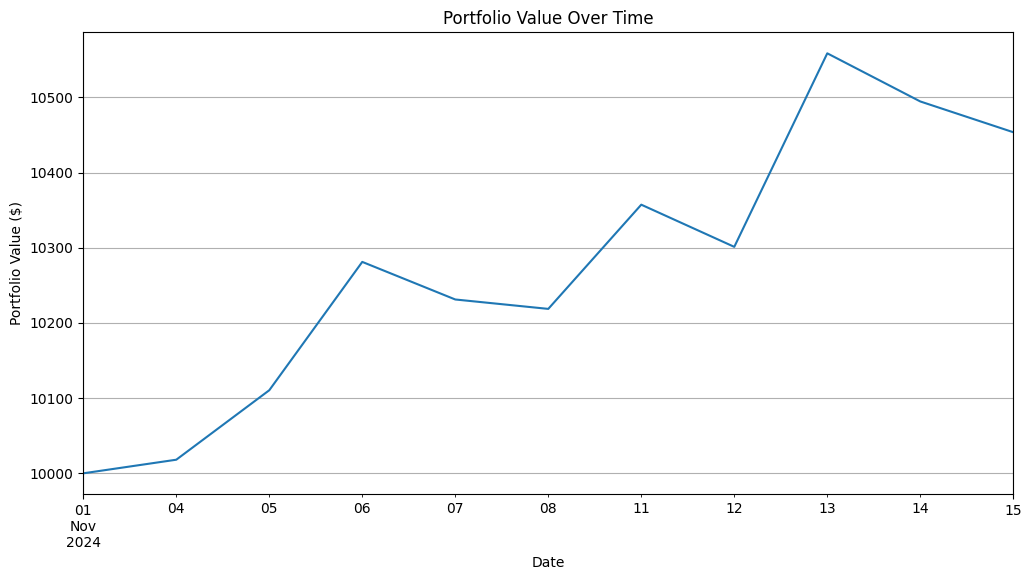

In [59]:
# Test the system
ticker = "MPC"
start_date = "2024-11-01"
end_date = "2024-11-15"
initial_capital = 10000

backtester = Backtester(
    agent=run_agent,
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    initial_capital=initial_capital
)

backtester.run_backtest()
backtester.analyze_performance()